# Dog vs. Cat Image Classifier Using Convolutional Neural Networks

In [1]:
#Libraries needed for code
import sys
import numpy as np
import cv2
#import os allows us to access our directory
import os
import sys
import pathlib
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = pathlib.Path("C:\\Users\\HP\\Desktop\\Python\\Image Classifier\\train")
TEST_DIR = pathlib.Path("C:\\Users\\HP\\Desktop\\Python\\Image Classifier\\test")
# Resize image to 50 px
IMG_SIZE=50
# Learning Rate
LR=1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'2conv-basic')

## Label the images

In [2]:
def label_img(img):
    #naming our pics->dog.93.png
    word_label=img.split('.')[-3]
    if word_label=='cat':
        return [1,0]
    elif word_label=='dog':
        return [0,1]

## Create the training data

In [24]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path = os.path.join (TRAIN_DIR, img)
        img =cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy',training_data)
    return training_data



## Process the test data

In [25]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [5]:
train_data=create_train_data()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [04:16<00:00, 97.37it/s]


## Convolutional Neural Network Using Tensorflow

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


C:\Users\HP\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


## Train the Neural Network

In [7]:
if os.path.exists('C:\\Users\\HP\\Desktop\\Python\\Image Classifier{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model Loaded...')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE,1)
test_y = [i[1] for i in test]


model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 3829  | total loss: 11.32805 | time: 140.222s
| Adam | epoch: 010 | loss: 11.32805 - acc: 0.5080 -- iter: 24448/24500
Training Step: 3830  | total loss: 11.34654 | time: 141.615s
| Adam | epoch: 010 | loss: 11.34654 - acc: 0.5072 | val_loss: 11.23662 - val_acc: 0.5120 -- iter: 24500/24500
--
INFO:tensorflow:C:\Users\HP\Desktop\Python\Image Classifier\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


In [26]:
test_data=process_test_data()


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:23<00:00, 148.84it/s]


## Plot our results

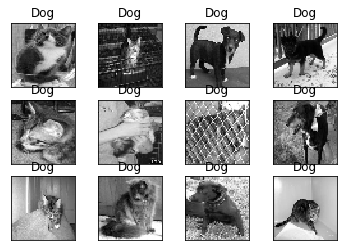

In [31]:
import matplotlib.pyplot as plt

test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else: 
        str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

Accuracy can be improved by increasing the size of the network to accomadate the 25,000 pics of training data. Why are all predictions viewed as Dog?